# Resources
- [The paper describing the mathematics of the model](https://arxiv.org/pdf/1907.08279.pdf)
- [The paper explaining how the degradation is estimated in the model](https://arxiv.org/abs/1907.09456)
- [github](https://github.com/slacgismo/StatisticalClearSky)

The package requires cvxpy <= 1.0.31 and mosek solver (which is available with an academic license)

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir
from src.data.import_data import *
from src.data.make_dataset import *
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt

from solardatatools import make_2d

# There is some weird error if numpy is imported before SCFM…
# It also requires a mosek license
from statistical_clear_sky.algorithm.iterative_fitting import *

# A signal from the basic dataset

In [2]:
# Load the data
index           = 1
path_to_zip_pkl = '../data/raw/synthetic_basic.zip'
df              = import_df_from_zip_pkl(path_to_zip_pkl, index=index, verbose=True)

time for importing dataframe: 0.70 seconds


In [3]:
df.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.0,1,1,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2629440 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 23:59:00-05:00
Freq: T
Data columns (total 8 columns):
Power            float64
POA              float64
Tamb             float64
Wind             float64
Degradation      float64
Soiling          int64
Faults           int64
minute_of_day    int64
dtypes: float64(5), int64(3)
memory usage: 180.5 MB


First convert the DataFrame into a 2-dimensional signal of the form $Power(\text{minute_of_day}, \text{day_of_year})$. However, we can not apply clipping removing on this data.

The function `make_2d` seems to discard the first and the last day of the DataFrame given to it by default.

In [5]:
signal_2d = make_2d(df[df.index.year <= 2017], key="Power", trim_start=False, trim_end=False)
signal_2d.shape

(1440, 1096)

The computation takes quite a long time. For example, simply to considering a single 3 year power singal, the algorithm take around 15mins

In [6]:
scsf = IterativeFitting(signal_2d)
scsf.execute(is_degradation_calculated=False)
clear_sky_signals = scsf.clear_sky_signals()

obtaining weights
obtaining initial value of component r0
Starting at Objective: 6.033e+06, f1: 9.678e+05, f2: 2.145e+00, f3: 2.216e+05, f4: 4.844e+06
    Minimizing left matrix
    Minimizing right matrix
Minimize R status: infeasible
Starting over and reversing minimization order.
obtaining initial value of component r0
    Minimizing right matrix
    Minimizing left matrix
1 - Objective: 3.342e+06, f1: 3.194e+06, f2: 6.607e+01, f3: 1.483e+05, f4: 4.573e-05
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
2 - Objective: 2.059e+06, f1: 1.913e+06, f2: 6.941e+01, f3: 1.454e+05, f4: 3.141e-05
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
3 - Objective: 1.263e+06, f1: 1.117e+06, f2: 4.965e+01, f3: 1.463e+05, f4: 4.480e-06
Caution: residuals increased
    Minimizing right matrix
    Minimizing left matrix
4 - Objective: 1.058e+06, f1: 9.093e+05, f2: 4.022e+01, f3: 1.491e+05, f4: 1.656e-05
    Minimizing right matrix
 

In [7]:
pickle.dump(scsf, open("scsf_basic_1_no_deg_3yr.p", "wb" ))

The tool provides a few plotting functions out of the box

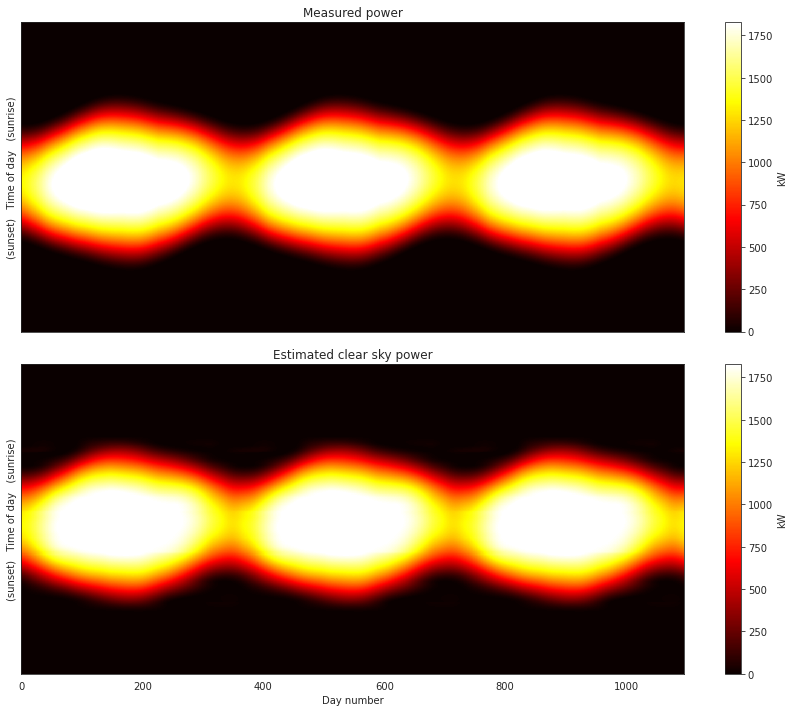

In [8]:
scsf.plot_measured_clear_matrices()
print()

Text(0, 0.5, 'Energy')

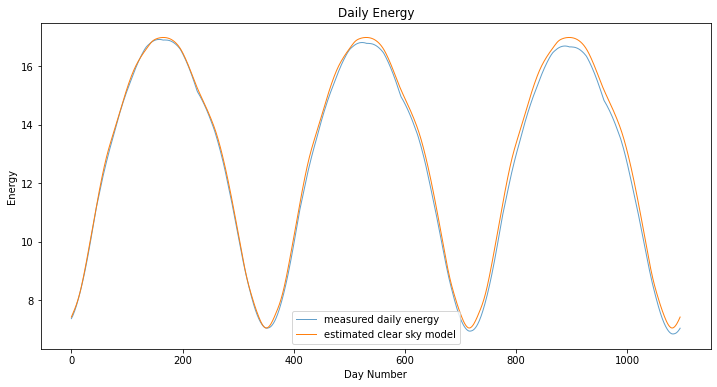

In [9]:
scsf.plot_energy(show_clear=True, show_days=False, scale_power=True)
plt.title('Daily Energy')
plt.xlabel('Day Number')
plt.ylabel('Energy')

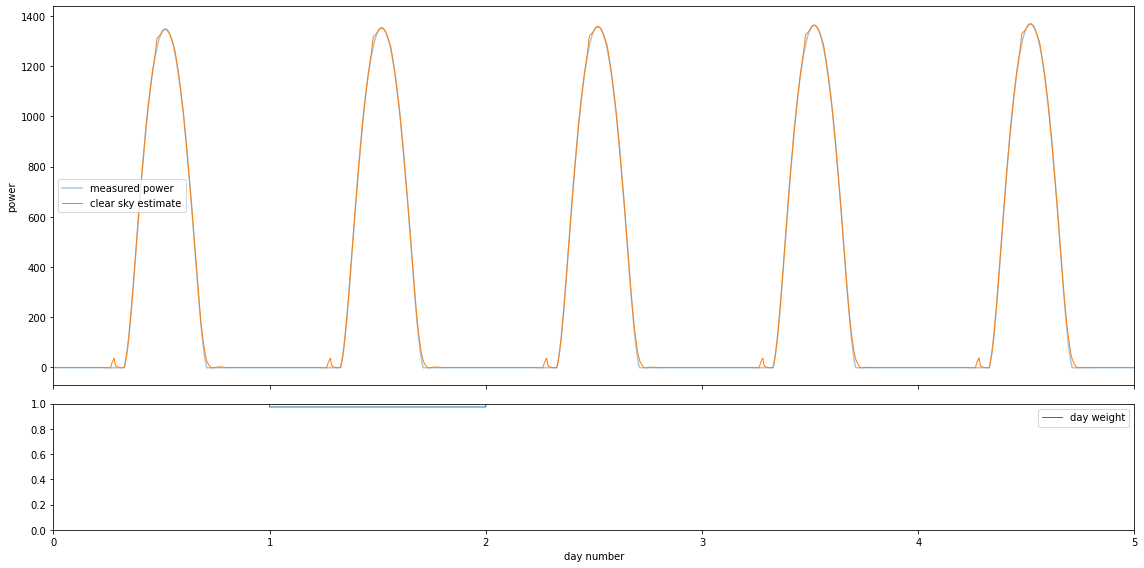

In [10]:
scsf.plot_time_series_with_weights()
print()

Next, create `new_df` a DataFrame which holds the power obtained by the clear sky statistical fitting algorithm.

In [11]:
sdf = df[df.index.year <= 2017]
cs_df = pd.DataFrame(index = sdf.index)
cs_df['minute_of_day'] = cs_df.index.minute + cs_df.index.hour*60
cs_df['Power'] = np.nan
for i in range(1440):
    cs_df.loc[cs_df.minute_of_day == i, 'Power'] = clear_sky_signals[i, :]

Text(0, 0.5, 'Power (kW)')

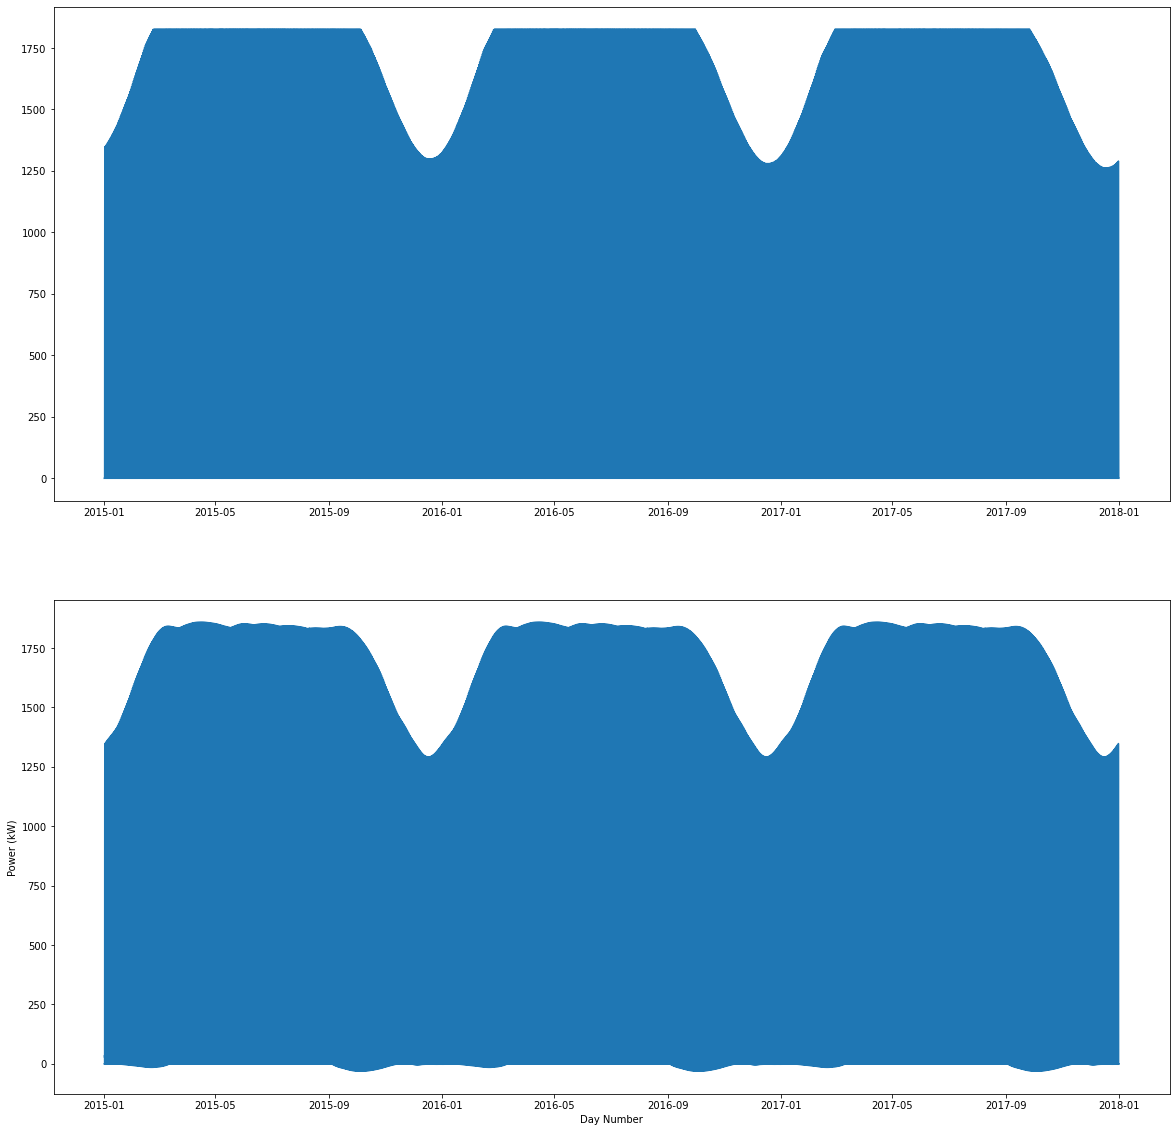

In [12]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(sdf.Power)
axs[1].plot(cs_df.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Compare the two signals using our downsampling with and without removal of data

In [13]:
sdf_processed = remove_clipping_with_universal_window(sdf, max_power=1800)
sdf_processed = downsample_dataframe(sdf_processed)
cs_df_processed = remove_clipping_with_universal_window(cs_df, max_power=1800)
cs_df_processed = downsample_dataframe(cs_df_processed)

(152468, 8)
(158103, 2)


Text(0, 0.5, 'Power (kW)')

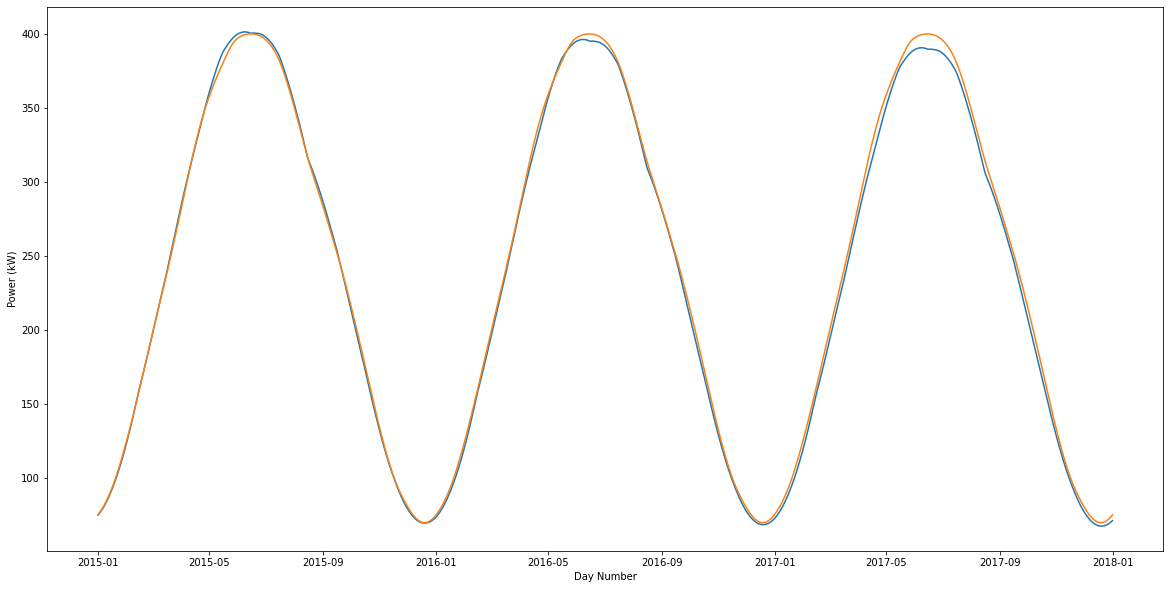

In [14]:
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(sdf_processed.Power)
ax.plot(cs_df_processed.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Text(0, 0.5, 'Power (kW)')

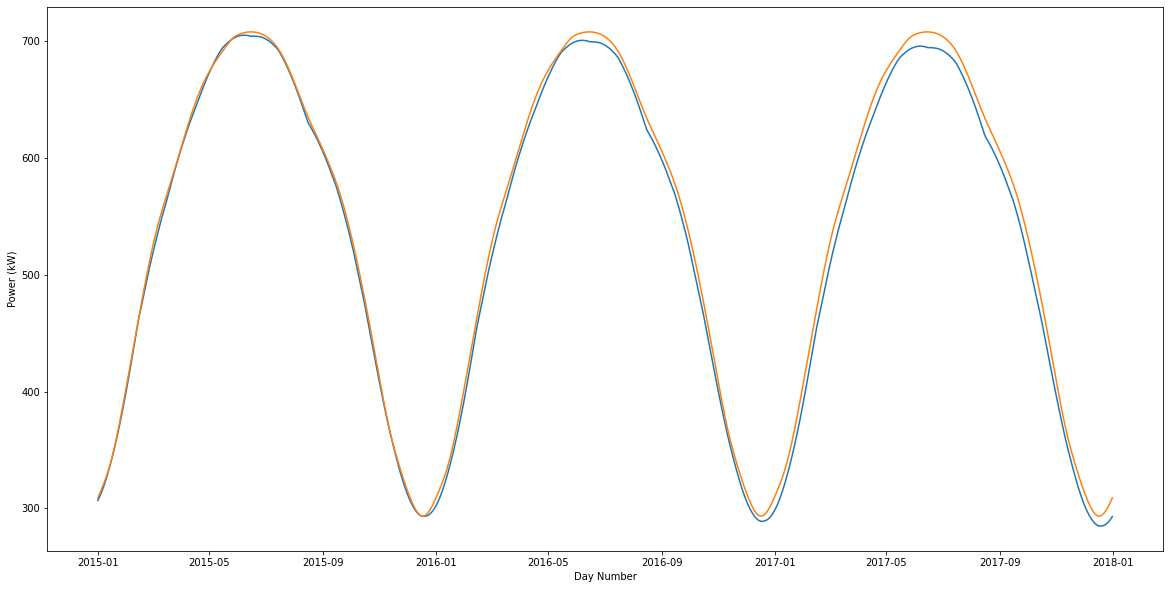

In [15]:
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(downsample_dataframe(sdf).Power)
ax.plot(downsample_dataframe(cs_df).Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Normalised power

In [16]:
norm_power = downsample_dataframe(sdf).Power.to_numpy() / downsample_dataframe(cs_df).Power.to_numpy()

Text(0, 0.5, 'Factor')

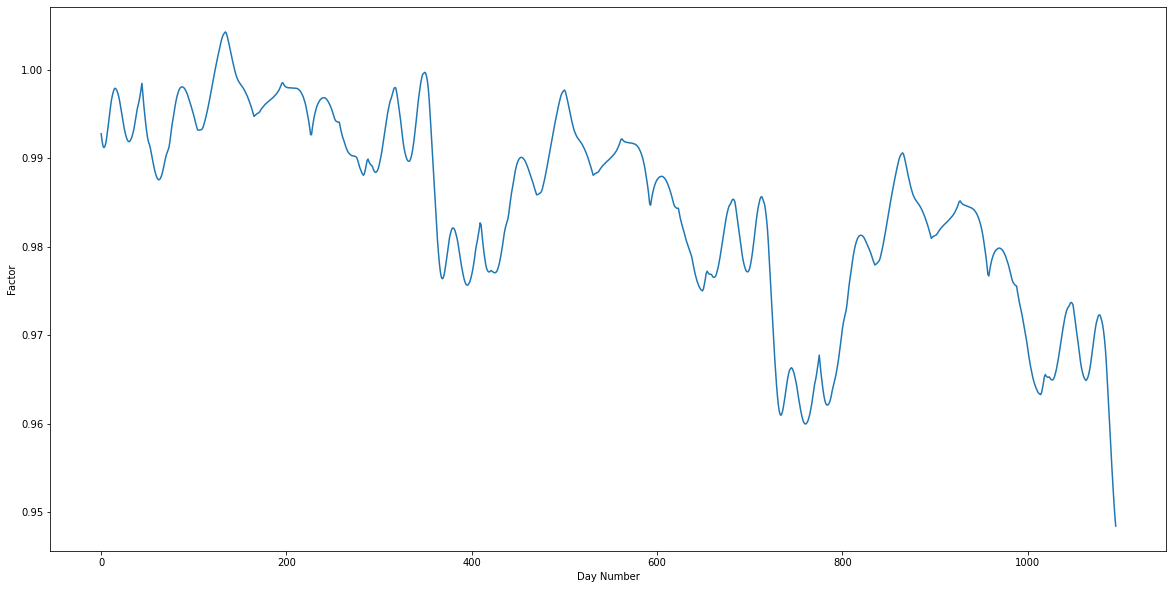

In [17]:
_, ax = plt.subplots(figsize=(20,10))
ax.plot(norm_power)
plt.xlabel('Day Number')
plt.ylabel('Factor')

In [18]:
rd, _ = np.polyfit(np.arange(len(norm_power)), norm_power, deg = 1)

In [19]:
print(f"Predicted yearly decay is {rd*365}")

Predicted yearly decay is -0.00941235615923898


Even for basic data set using statistical clear sky fitting doesn't seem to give good noramlisation

# A signal from the basic dataset


We repeat the above steps for one of the signals from the soiling dataset

In [20]:
# Load the data
index           = 1
path_to_zip_pkl = '../data/raw/synthetic_soil.zip'
df              = import_df_from_zip_pkl(path_to_zip_pkl, index=index, verbose=True)

time for importing dataframe: 0.68 seconds


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2629440 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 23:59:00-05:00
Freq: T
Data columns (total 8 columns):
Power            float64
POA              float64
Tamb             float64
Wind             float64
Degradation      float64
Soiling          float64
Faults           int64
minute_of_day    int64
dtypes: float64(6), int64(2)
memory usage: 180.5 MB


In [22]:
df.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,4


Convet the signal into a 2-dimentional matrix

In [23]:
signal_2d = make_2d(df[df.index.year <= 2017], key="Power", trim_start=False, trim_end=False)
signal_2d.shape

(1440, 1096)

Run the algorithm 

In [24]:
scsf = IterativeFitting(signal_2d)
scsf.execute(is_degradation_calculated=False)
clear_sky_signals = scsf.clear_sky_signals()

obtaining weights
obtaining initial value of component r0
Starting at Objective: 2.740e+07, f1: 1.285e+06, f2: 1.769e+00, f3: 9.153e+06, f4: 1.696e+07
    Minimizing left matrix
    Minimizing right matrix
1 - Objective: 4.323e+06, f1: 4.100e+06, f2: 3.436e+01, f3: 2.235e+05, f4: 1.362e-04
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 2.748e+06, f1: 2.531e+06, f2: 3.847e+01, f3: 2.173e+05, f4: 1.761e-04
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 2.410e+06, f1: 2.185e+06, f2: 3.165e+01, f3: 2.257e+05, f4: 5.632e-05
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 2.283e+06, f1: 2.059e+06, f2: 3.398e+01, f3: 2.239e+05, f4: 8.363e-05
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
5 - Objective: 2.237e+06, f1: 2.011e+06, f2: 3.139e+01, f3: 2.259e+05, f4: 4.970e-05
Caution: residuals increased
    

In [25]:
pickle.dump(scsf, open("scsf_soil_1_no_deg_3yr.p", "wb" ))

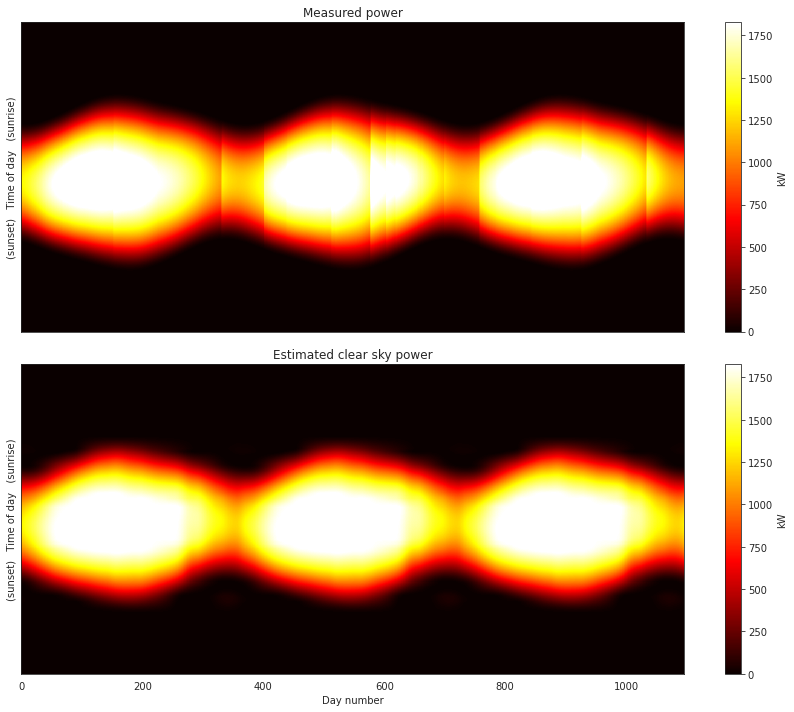

In [26]:
scsf.plot_measured_clear_matrices()
print()

Text(0, 0.5, 'Power (kW)')

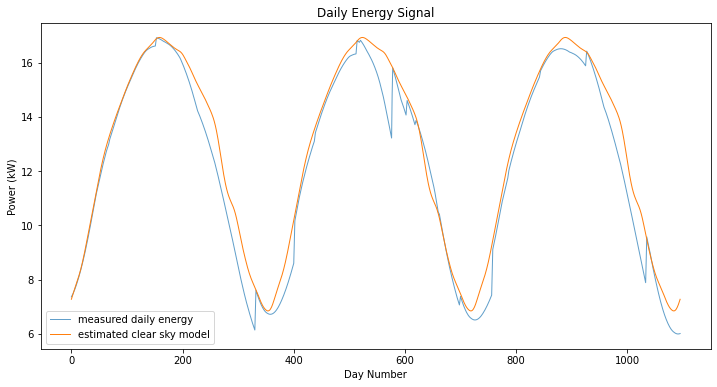

In [27]:
scsf.plot_energy(show_clear=True, show_days=False, scale_power=True)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Next, create `cs_df` a DataFrame which holds the power obtained by the clear sky statistical fitting algorithm.

In [28]:
sdf = df[df.index.year <= 2017]
cs_df = pd.DataFrame(index = sdf.index)
cs_df['minute_of_day'] = cs_df.index.minute + cs_df.index.hour*60
cs_df['Power'] = np.nan
for i in range(1440):
    cs_df.loc[cs_df.minute_of_day == i, 'Power'] = clear_sky_signals[i, :]

Plot the power versus time for the actual and modeled outputs

Text(0, 0.5, 'Power (kW)')

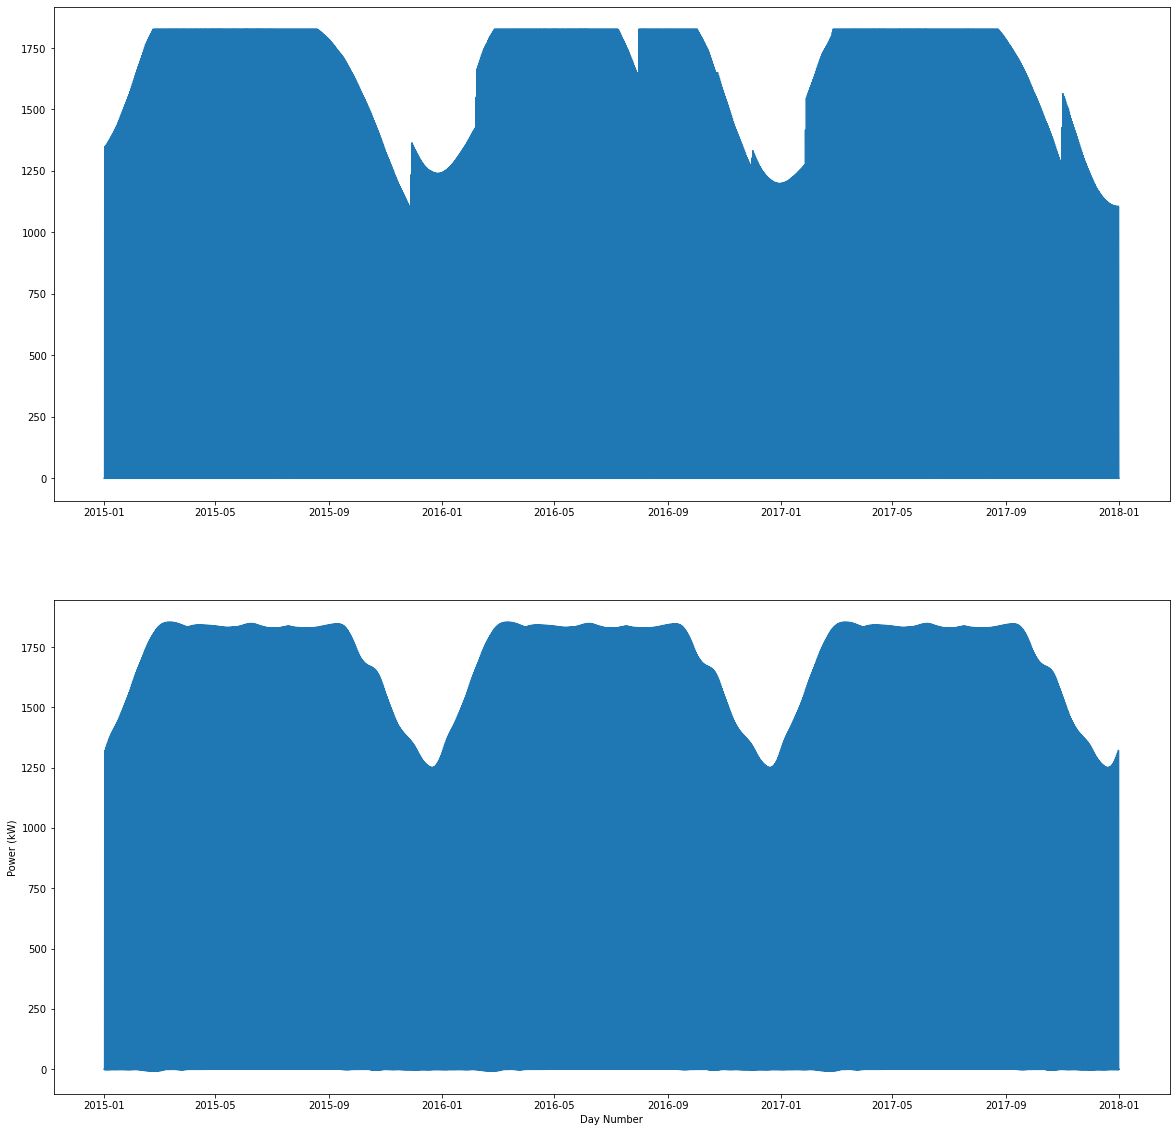

In [29]:
_, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(sdf.Power)
axs[1].plot(cs_df.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Compare the two signals using our downsampling with and without removal of data.

First, start without removing any data

Text(0, 0.5, 'Power (kW)')

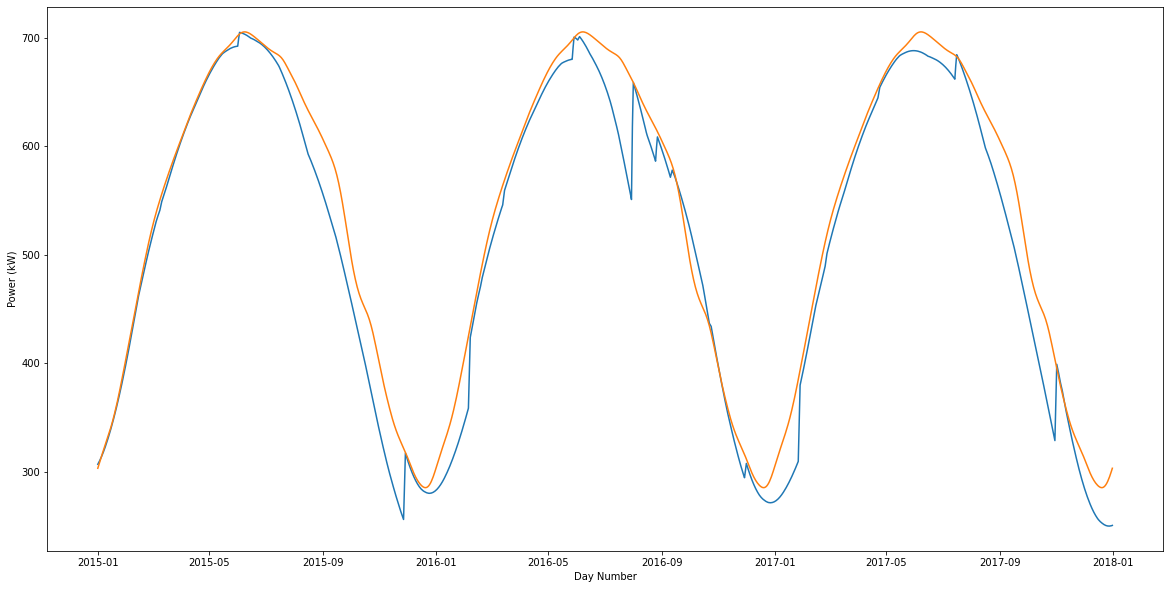

In [30]:
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(downsample_dataframe(sdf).Power)
ax.plot(downsample_dataframe(cs_df).Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Remove clipping using universal window and clipping power set to 1800. Note that removing the night data might not work, since the clear sky does not have value -1 for the night signal.

In [31]:
sdf_processed = remove_clipping_with_universal_window(sdf, max_power=1860)
sdf_processed = downsample_dataframe(sdf_processed)
cs_df_processed = remove_clipping_with_universal_window(cs_df, max_power=1860)
cs_df_processed = downsample_dataframe(cs_df_processed)

(0, 8)
(0, 2)


Text(0, 0.5, 'Power (kW)')

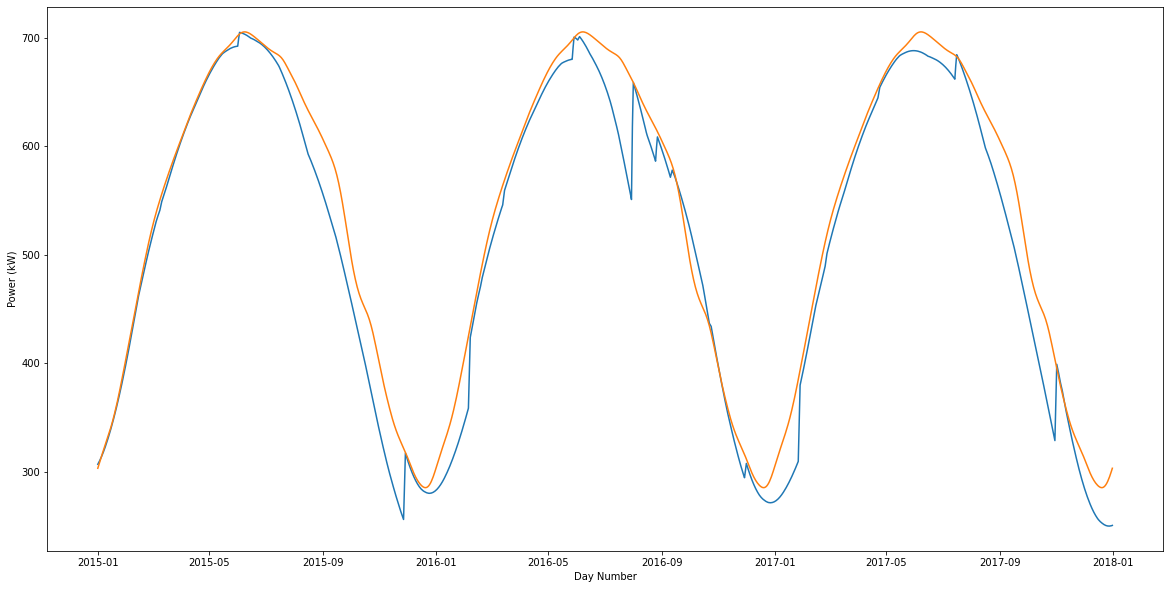

In [32]:
_, ax = plt.subplots(figsize=(20, 10))

ax.plot(sdf_processed.Power)
ax.plot(cs_df_processed.Power)
plt.xlabel('Day Number')
plt.ylabel('Power (kW)')

Finally, let's consider the normalised power signal (without removal of clipping)

In [33]:
norm_power = downsample_dataframe(sdf).Power.to_numpy() / downsample_dataframe(cs_df).Power.to_numpy()

Text(0, 0.5, 'Factor')

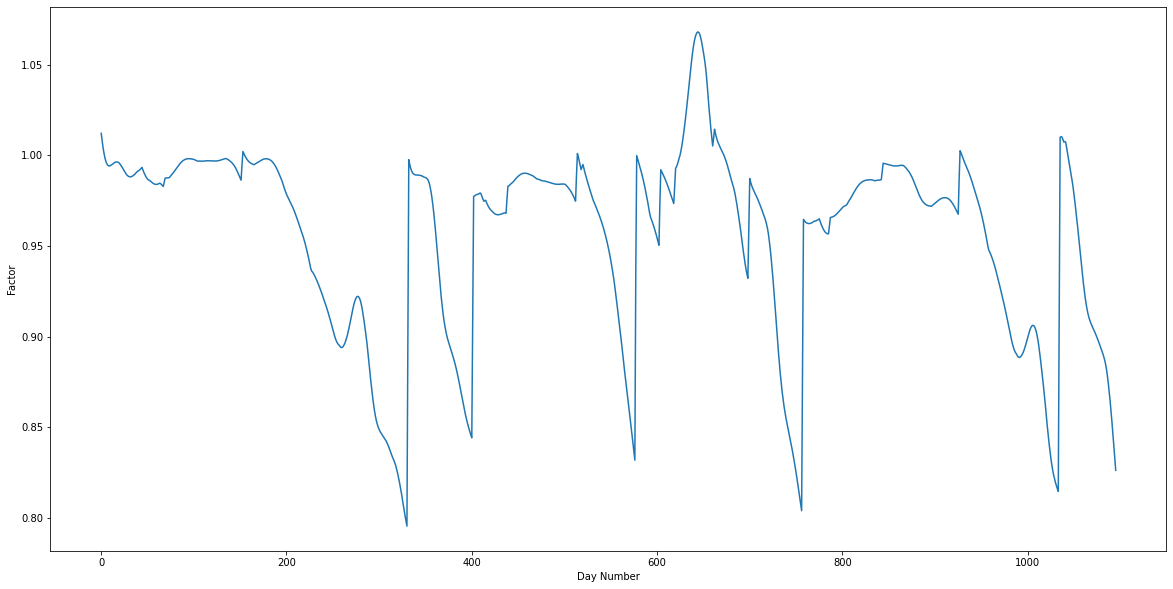

In [34]:
_, ax = plt.subplots(figsize=(20,10))
ax.plot(norm_power)
plt.xlabel('Day Number')
plt.ylabel('Factor')

# Brief summary

Clear Sky Statistical Model has managed to create a rather good model (for both basic and soiling signals) for power output assuming clear-sky. This could be used to noramlise the the power output and potentially for soiling detection, since seasonal changes are mostly removed. The only disdvatage of this method is a long time required to process a single signal (around 30mins for a 5yr signal).